In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Read the CSV file
df = pd.read_csv('new_data.csv')

# Display the data types and first few rows
print(df.dtypes)
print("\nFirst few rows of the dataset:")
df.head()

Unnamed: 0                                 int64
Outcode                                   object
Postcode                                  object
Num_meters                                 int64
Total_cons_kwh                           float64
Mean_cons_kwh                            float64
Median_cons_kwh                          float64
Total                                      int64
Males                                      int64
Females                                    int64
Occupied_Households                        int64
Cluster                                    int64
Electricity_Consumption_per_Household    float64
Population_Density                       float64
Energy_Efficiency                        float64
dtype: object

First few rows of the dataset:


,Unnamed: 0,Outcode,Postcode,Num_meters,Total_cons_kwh,Mean_cons_kwh,Median_cons_kwh,Total,Males,Females,Occupied_Households,Cluster,Electricity_Consumption_per_Household,Population_Density,Energy_Efficiency
0,0,AL1,AL1 1BH,46,281294.98,6115.108261,5902.8,52,15,37,41,0,6860.853171,1.268293,5409.518846
1,1,AL1,AL1 1BZ,7,29805.40,4257.914286,4979.2,18,11,7,12,2,2483.783333,1.500000,1655.855556
2,2,AL1,AL1 1DU,5,34775.10,6955.020000,4940.3,81,45,36,27,0,1287.966667,3.000000,429.322222
3,3,AL1,AL1 1JJ,6,43955.90,7325.983333,4194.3,71,33,38,22,0,1997.995455,3.227273,619.097183
4,4,AL1,AL1 1JQ,8,35806.40,4475.800000,4013.0,50,31,19,22,2,1627.563636,2.272727,716.128000


DATA CLEANING

In [2]:
# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for NaN values and display the count per column
nan_counts = df.isna().sum()
print("NaN values per column:")
print(nan_counts)

# Drop rows with NaN values
df_cleaned = df.dropna()

# Save the cleaned dataset
df_cleaned.to_csv('new_data_cleaned.csv', index=False)

# Display the first few rows of the cleaned dataframe
print("\nFirst few rows of the cleaned dataframe:")
df_cleaned.head()

NaN values per column:
Unnamed: 0                                0
Outcode                                   0
Postcode                                  0
Num_meters                                0
Total_cons_kwh                            0
Mean_cons_kwh                             0
Median_cons_kwh                           0
Total                                     0
Males                                     0
Females                                   0
Occupied_Households                       0
Cluster                                   0
Electricity_Consumption_per_Household    12
Population_Density                       12
Energy_Efficiency                        12
dtype: int64

First few rows of the cleaned dataframe:


,Unnamed: 0,Outcode,Postcode,Num_meters,Total_cons_kwh,Mean_cons_kwh,Median_cons_kwh,Total,Males,Females,Occupied_Households,Cluster,Electricity_Consumption_per_Household,Population_Density,Energy_Efficiency
0,0,AL1,AL1 1BH,46,281294.98,6115.108261,5902.8,52,15,37,41,0,6860.853171,1.268293,5409.518846
1,1,AL1,AL1 1BZ,7,29805.40,4257.914286,4979.2,18,11,7,12,2,2483.783333,1.500000,1655.855556
2,2,AL1,AL1 1DU,5,34775.10,6955.020000,4940.3,81,45,36,27,0,1287.966667,3.000000,429.322222
3,3,AL1,AL1 1JJ,6,43955.90,7325.983333,4194.3,71,33,38,22,0,1997.995455,3.227273,619.097183
4,4,AL1,AL1 1JQ,8,35806.40,4475.800000,4013.0,50,31,19,22,2,1627.563636,2.272727,716.128000


INJECTED OUTLIERS

In [23]:
from sklearn.metrics import precision_recall_fscore_support


# Function to inject outliers
def inject_outliers(X_scaled, contamination=0.05):
    n_samples, n_features = X_scaled.shape
    n_outliers = int(contamination * n_samples)
    
    # Create a copy of X
    X_with_outliers = X_scaled.copy()
    
    # Randomly select samples to be outliers
    outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
    
    # Inject outliers by multiplying selected samples by a large factor
    X_with_outliers[outlier_indices] *= np.random.uniform(10, 20, size=(n_outliers, n_features))
    
    # Create true labels (1 for outliers, -1 for inliers)
    y_true = np.ones(n_samples) * -1
    y_true[outlier_indices] = 1
    
    return X_with_outliers, y_true

# Inject outliers
X_with_outliers, y_true = inject_outliers(X_scaled, contamination=0.05)

# LOF
lof = LocalOutlierFactor(contamination=0.05, n_neighbors=20)
y_pred_lof = lof.fit_predict(X_with_outliers)

# Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
y_pred_iso = iso_forest.fit_predict(X_with_outliers)

# Ensemble (combining LOF and Isolation Forest)
y_pred_ensemble = np.where((y_pred_lof == -1) | (y_pred_iso == -1), -1, 1)

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1)
    return precision, recall, f1

metrics_lof = calculate_metrics(y_true, y_pred_lof)
metrics_iso = calculate_metrics(y_true, y_pred_iso)
metrics_ensemble = calculate_metrics(y_true, y_pred_ensemble)

# Calculate percentage of actual outliers caught
def percentage_caught(y_true, y_pred):
    return np.sum((y_true == 1) & (y_pred == -1)) / np.sum(y_true == 1) * 100

percent_caught_lof = percentage_caught(y_true, y_pred_lof)
percent_caught_iso = percentage_caught(y_true, y_pred_iso)
percent_caught_ensemble = percentage_caught(y_true, y_pred_ensemble)

# Create a DataFrame to display the results
results = {
    'Method': ['LOF', 'Isolation Forest', 'Ensemble'],
    'Precision': [metrics_lof[0], metrics_iso[0], metrics_ensemble[0]],
    'Recall': [metrics_lof[1], metrics_iso[1], metrics_ensemble[1]],
    'F1-score': [metrics_lof[2], metrics_iso[2], metrics_ensemble[2]],
    'Percentage of injected outliers caught': [percent_caught_lof, percent_caught_iso, percent_caught_ensemble]
}

results_df = pd.DataFrame(results)

# Display the results in tabular form
from IPython.display import display

print("Results in tabular form:")
display(results_df)

# Calculate the actual number of injected outliers
actual_outliers = np.sum(y_true == 1)
LOF_detect = 0.01*percent_caught_lof*actual_outliers
Iso_detect = 0.01*percent_caught_iso*actual_outliers
Ensemble_detect = 0.01*percent_caught_ensemble*actual_outliers
print(f"Number of injected outliers: {actual_outliers}")
print(f"Number of injected outliers detected by LOF: {LOF_detect}")
print(f"Number of injected outliers detected by Isolation Forest: {Iso_detect}")
print(f"Number of injected outliers detected by Ensemble Method: {Ensemble_detect}")
print(f"Percentage of injected outliers: {(actual_outliers / len(y_true)) * 100:.2f}%")

Results in tabular form:


,Method,Precision,Recall,F1-score,Percentage of injected outliers caught
0,LOF,0.046908,0.891401,0.089127,10.859939
1,Isolation Forest,0.000233,0.004428,0.000443,99.557213
2,Ensemble,0.000116,0.002097,0.000219,99.790259


Number of injected outliers: 4291
Number of injected outliers detected by LOF: 466.0
Number of injected outliers detected by Isolation Forest: 4272.0
Number of injected outliers detected by Ensemble Method: 4282.0
Percentage of injected outliers: 5.00%


OUTLIER DETECTION TEST

+----------------------+----------------------+--------------------------+
| Method               |   Number of Outliers | Percentage of Outliers   |
+======================+======================+==========================+
| Local Outlier Factor |                 8584 | 10.00%                   |
+----------------------+----------------------+--------------------------+
| Isolation Forest     |                 8584 | 10.00%                   |
+----------------------+----------------------+--------------------------+
| Ensemble Method      |                14850 | 17.30%                   |
+----------------------+----------------------+--------------------------+

Agreement between methods:
+-------------------------------+-----------------------------+---------------------------+
| Agreement Between             |   Number of Common Outliers | Percentage of Agreement   |
+===============================+=============================+===========================+
| LOF and Isolation F

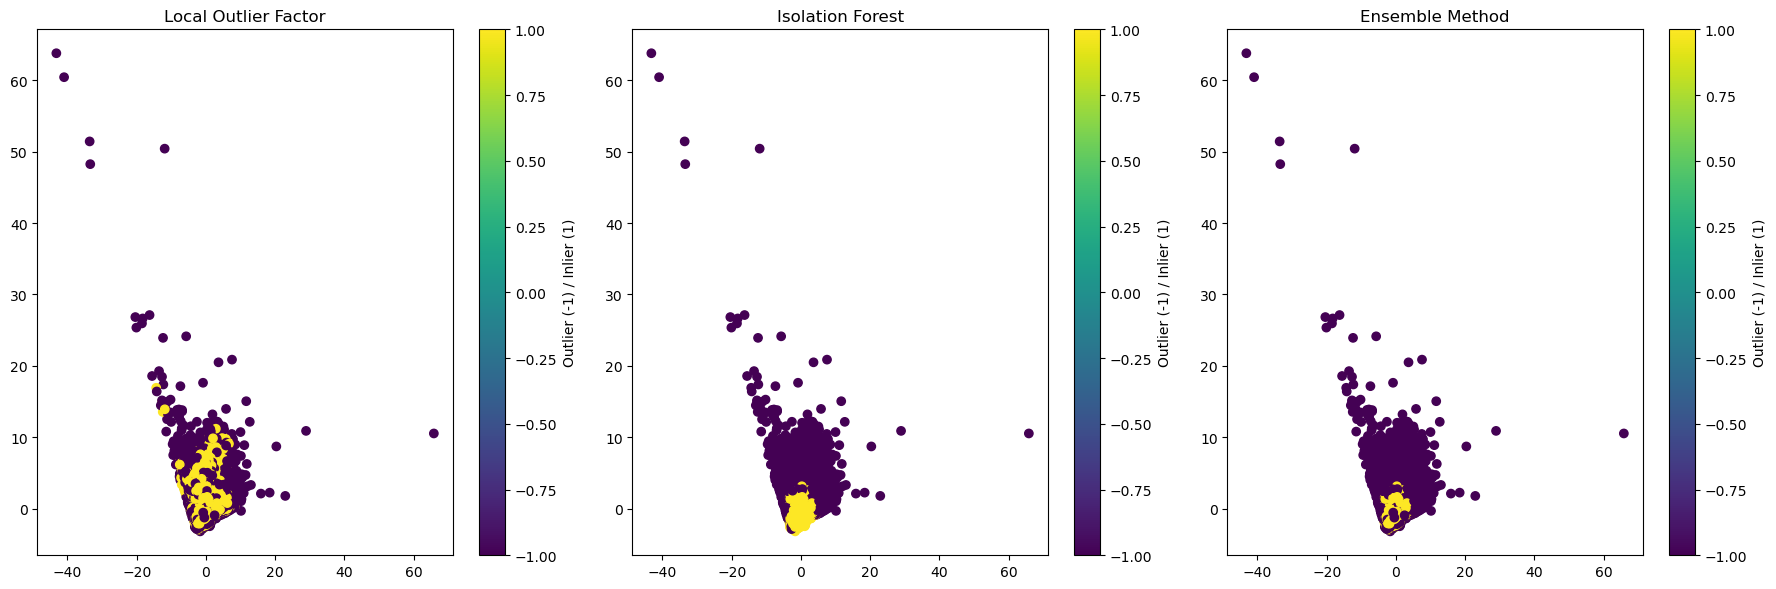

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from tabulate import tabulate

# Read the cleaned CSV file
df = pd.read_csv('new_data_cleaned.csv')

# Initialize LabelEncoder
le = LabelEncoder()

# Label encode 'Outcode' and 'Postcode'
df['Outcode_encoded'] = le.fit_transform(df['Outcode'])
df['Postcode_encoded'] = le.fit_transform(df['Postcode'])

# Select numerical columns for outlier detection
numerical_cols = ['Num_meters', 'Total_cons_kwh', 'Mean_cons_kwh', 'Median_cons_kwh', 'Total', 
                  'Males', 'Females', 'Occupied_Households', 'Cluster', 
                  'Electricity_Consumption_per_Household', 'Population_Density', 'Energy_Efficiency',
                  'Outcode_encoded', 'Postcode_encoded']

# Prepare the data
X = df[numerical_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred_lof = lof.fit_predict(X_scaled)
lof_outliers = sum(y_pred_lof == -1)

# Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
y_pred_iso = iso_forest.fit_predict(X_scaled)
iso_outliers = sum(y_pred_iso == -1)

# Ensemble method (combining LOF and Isolation Forest)
y_pred_ensemble = np.where((y_pred_lof == -1) | (y_pred_iso == -1), -1, 1)
ensemble_outliers = sum(y_pred_ensemble == -1)

# Calculate percentages
total_samples = len(X)
lof_percentage = (lof_outliers / total_samples) * 100
iso_percentage = (iso_outliers / total_samples) * 100
ensemble_percentage = (ensemble_outliers / total_samples) * 100

# Create a comparison table
comparison_table = [
    ["Method", "Number of Outliers", "Percentage of Outliers"],
    ["Local Outlier Factor", lof_outliers, f"{lof_percentage:.2f}%"],
    ["Isolation Forest", iso_outliers, f"{iso_percentage:.2f}%"],
    ["Ensemble Method", ensemble_outliers, f"{ensemble_percentage:.2f}%"]
]

print(tabulate(comparison_table, headers="firstrow", tablefmt="grid"))

# Calculate agreement between methods
lof_iso_agreement = sum((y_pred_lof == -1) & (y_pred_iso == -1))
lof_ensemble_agreement = sum((y_pred_lof == -1) & (y_pred_ensemble == -1))
iso_ensemble_agreement = sum((y_pred_iso == -1) & (y_pred_ensemble == -1))

agreement_table = [
    ["Agreement Between", "Number of Common Outliers", "Percentage of Agreement"],
    ["LOF and Isolation Forest", lof_iso_agreement, f"{(lof_iso_agreement / min(lof_outliers, iso_outliers)) * 100:.2f}%"],
    ["LOF and Ensemble", lof_ensemble_agreement, f"{(lof_ensemble_agreement / lof_outliers) * 100:.2f}%"],
    ["Isolation Forest and Ensemble", iso_ensemble_agreement, f"{(iso_ensemble_agreement / iso_outliers) * 100:.2f}%"]
]

print("\nAgreement between methods:")
print(tabulate(agreement_table, headers="firstrow", tablefmt="grid"))

# Visualize outliers (using the first two principal components for simplicity)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(18, 6))

# LOF
plt.subplot(131)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_lof, cmap='viridis')
plt.title('Local Outlier Factor')
plt.colorbar(label='Outlier (-1) / Inlier (1)')

# Isolation Forest
plt.subplot(132)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_iso, cmap='viridis')
plt.title('Isolation Forest')
plt.colorbar(label='Outlier (-1) / Inlier (1)')

# Ensemble
plt.subplot(133)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_ensemble, cmap='viridis')
plt.title('Ensemble Method')
plt.colorbar(label='Outlier (-1) / Inlier (1)')

plt.tight_layout()
plt.show()

DATASET LABELLING

In [7]:

# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred_lof = lof.fit_predict(X_scaled)

# Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
y_pred_iso = iso_forest.fit_predict(X_scaled)

# Ensemble method (combining LOF and Isolation Forest)
y_pred_ensemble = np.where((y_pred_lof == -1) | (y_pred_iso == -1), -1, 1)

# Label the dataset
# 1 if anomalous, 0 if normal
df['Anomaly'] = np.where(y_pred_ensemble == -1, 1, 0)

# Save the labeled dataset
df.to_csv('new_data_labeled.csv', index=False)

# Display the first few rows of the labeled dataframe
print("\nFirst few rows of the labeled dataframe:")
df.head()


First few rows of the labeled dataframe:


,Unnamed: 0,Outcode,Postcode,Num_meters,Total_cons_kwh,Mean_cons_kwh,Median_cons_kwh,Total,Males,Females,Occupied_Households,Cluster,Electricity_Consumption_per_Household,Population_Density,Energy_Efficiency,Outcode_encoded,Postcode_encoded,Anomaly
0,0,AL1,AL1 1BH,46,281294.98,6115.108261,5902.8,52,15,37,41,0,6860.853171,1.268293,5409.518846,0,0,1
1,1,AL1,AL1 1BZ,7,29805.40,4257.914286,4979.2,18,11,7,12,2,2483.783333,1.500000,1655.855556,0,1,0
2,2,AL1,AL1 1DU,5,34775.10,6955.020000,4940.3,81,45,36,27,0,1287.966667,3.000000,429.322222,0,2,0
3,3,AL1,AL1 1JJ,6,43955.90,7325.983333,4194.3,71,33,38,22,0,1997.995455,3.227273,619.097183,0,3,0
4,4,AL1,AL1 1JQ,8,35806.40,4475.800000,4013.0,50,31,19,22,2,1627.563636,2.272727,716.128000,0,4,1


CHECK CLASS IMBALANCE

Class counts:
Anomaly
0    70984
1    14850
Name: count, dtype: int64


C:\Users\EZENWAJIAKU CHINEDU\AppData\Local\Temp\ipykernel_22036\2134117651.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Anomaly', data=data, palette='viridis')


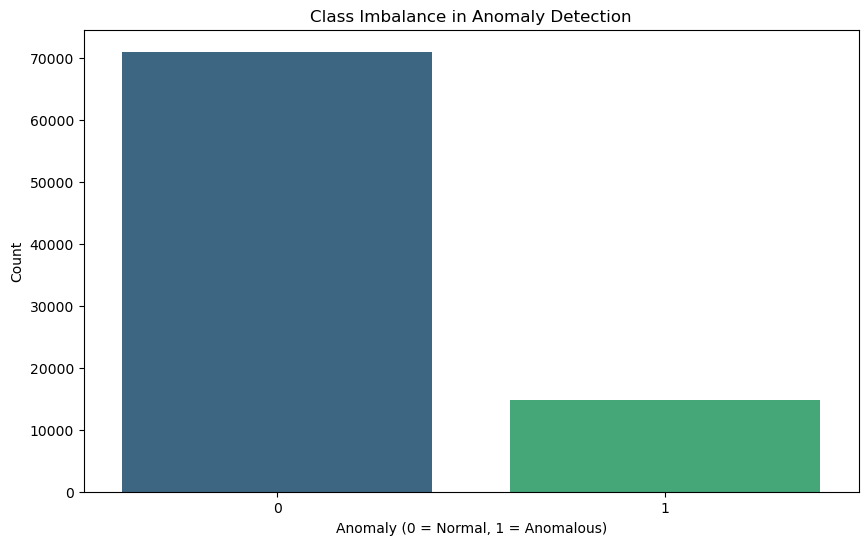

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Read the labeled CSV file
data = pd.read_csv('new_data_labeled.csv')

# Check for class imbalance
class_counts = data['Anomaly'].value_counts()
print("Class counts:")
print(class_counts)

# Visualize class imbalance
plt.figure(figsize=(10, 6))
sns.countplot(x='Anomaly', data=data, palette='viridis')
plt.title('Class Imbalance in Anomaly Detection')
plt.xlabel('Anomaly (0 = Normal, 1 = Anomalous)')
plt.ylabel('Count')
plt.show()

APPLYING SMOTE TO FIX THE CLASS IMBALANCE

New class counts after SMOTE:
Anomaly
1    70984
0    70984
Name: count, dtype: int64


C:\Users\EZENWAJIAKU CHINEDU\AppData\Local\Temp\ipykernel_22036\3585828986.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')
C:\Users\EZENWAJIAKU CHINEDU\AppData\Local\Temp\ipykernel_22036\3585828986.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='viridis')


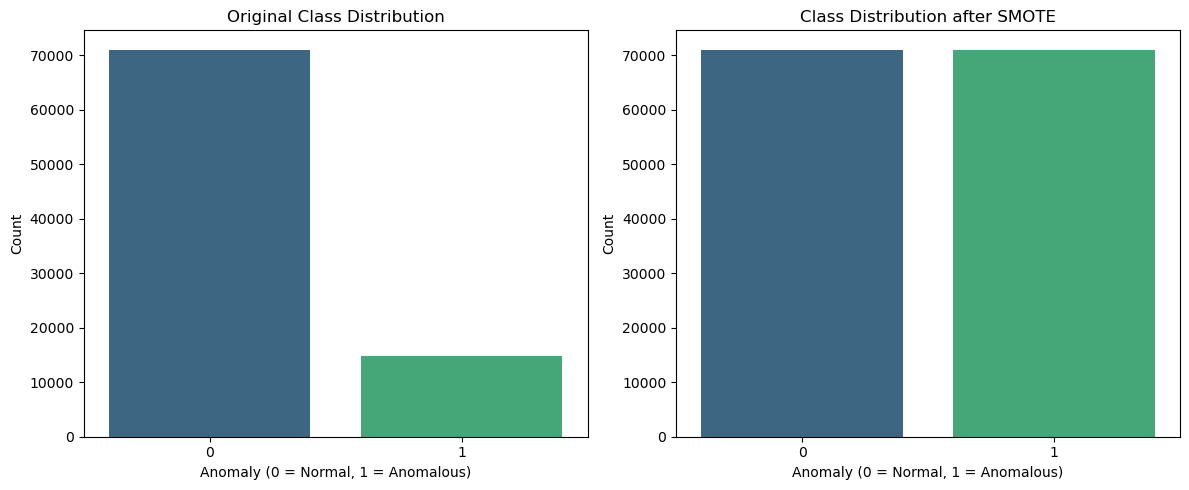

Original dataset shape:  (85834, 15)
Resampled dataset shape:  (141968, 15)


In [9]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler


# Separate features and target variable
X = data.drop(['Anomaly', 'Outcode', 'Postcode'], axis=1)  
# Dropping non-numeric columns
y = data['Anomaly']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Check new class distribution
new_class_counts = pd.Series(y_resampled).value_counts()
print("New class counts after SMOTE:")
print(new_class_counts)

# Visualize new class distribution
plt.figure(figsize=(12, 5))

# Original distribution
plt.subplot(1, 2, 1)
sns.countplot(x=y, palette='viridis')
plt.title('Original Class Distribution')
plt.xlabel('Anomaly (0 = Normal, 1 = Anomalous)')
plt.ylabel('Count')

# New distribution after SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled, palette='viridis')
plt.title('Class Distribution after SMOTE')
plt.xlabel('Anomaly (0 = Normal, 1 = Anomalous)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Save the resampled data
resampled_data = pd.DataFrame(X_resampled, columns=X.columns)
resampled_data['Anomaly'] = y_resampled

#resampled_df.to_csv('new_data_resampled.csv', index=False)
#Print shape of original and resampled datasets
print("Original dataset shape: ", X.shape)
print("Resampled dataset shape: ", X_resampled.shape)

SPLITTING THE DATA FOR MODELLING

In [10]:
from sklearn.model_selection import train_test_split


# Separate features and target
X = resampled_data.drop('Anomaly', axis=1)
y = resampled_data['Anomaly']

# First, split off the test set (15% of the data)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Then split the remaining data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)  # 0.1765 is 15/85, to get 15% of the original data

# Check the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# Check the distribution of classes in each set
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in validation set:")
print(y_val.value_counts(normalize=True))

print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

# Save the splits
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df.to_csv('train_set.csv', index=False)
val_df.to_csv('validation_set.csv', index=False)
test_df.to_csv('test_set.csv', index=False)

Training set shape: (99373, 15)
Validation set shape: (21299, 15)
Test set shape: (21296, 15)

Class distribution in training set:
Anomaly
1    0.500005
0    0.499995
Name: proportion, dtype: float64

Class distribution in validation set:
Anomaly
0    0.500023
1    0.499977
Name: proportion, dtype: float64

Class distribution in test set:
Anomaly
0    0.5
1    0.5
Name: proportion, dtype: float64


MODEL TRAINING


Training and evaluating Random Forest...


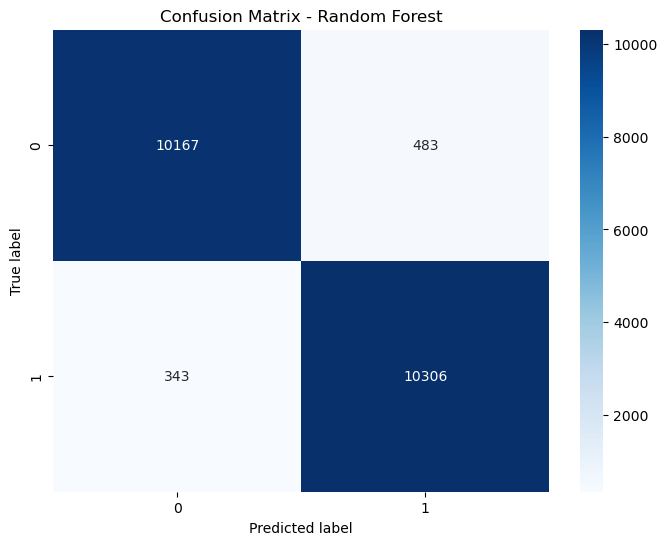

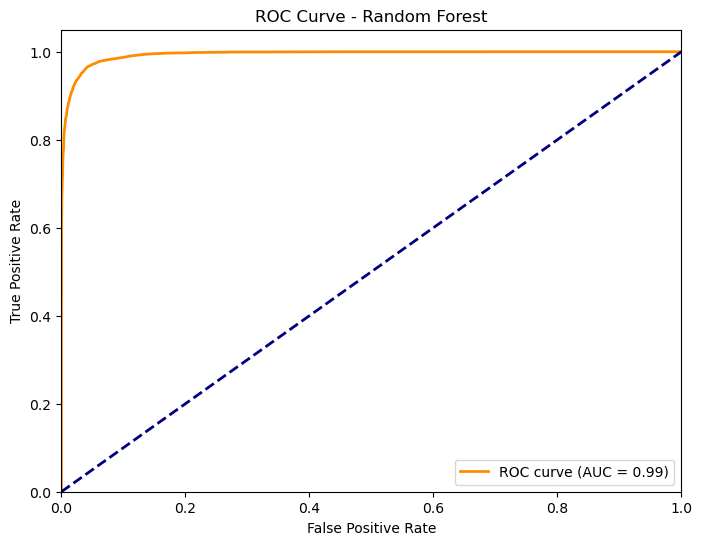


Training and evaluating Decision Tree...


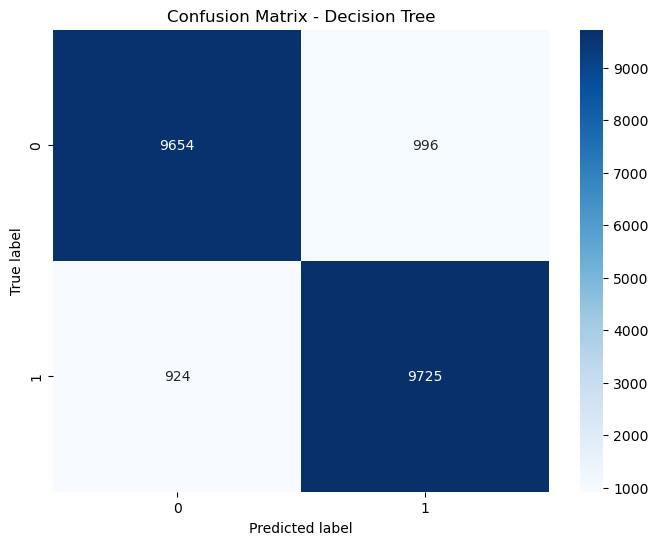

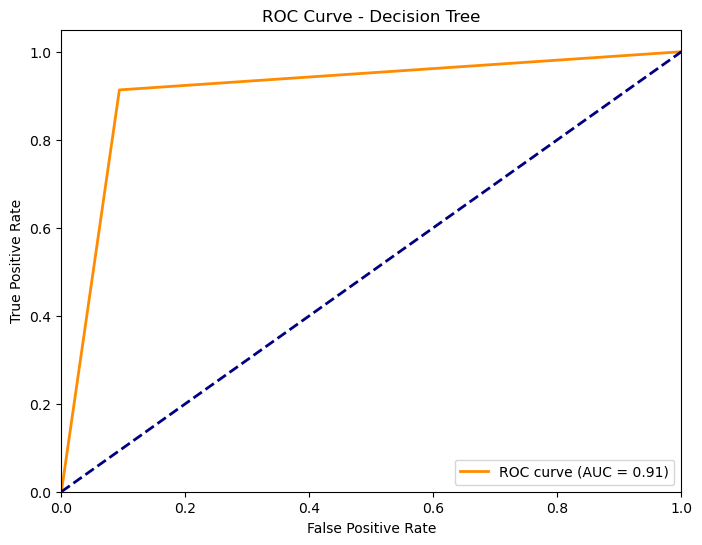


Training and evaluating KNN...


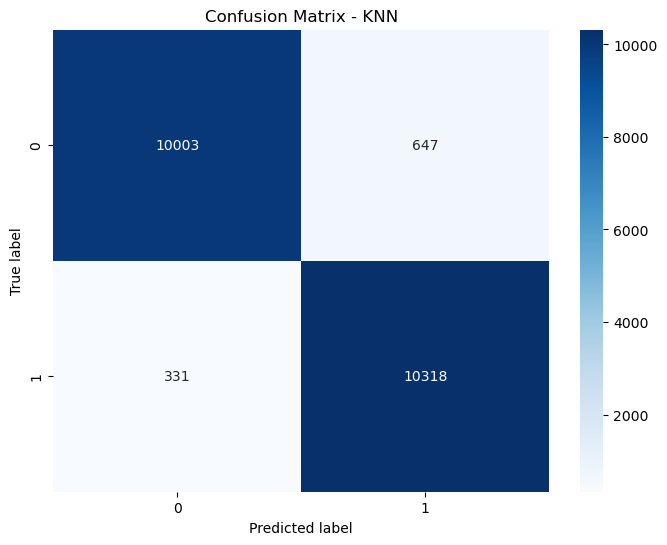

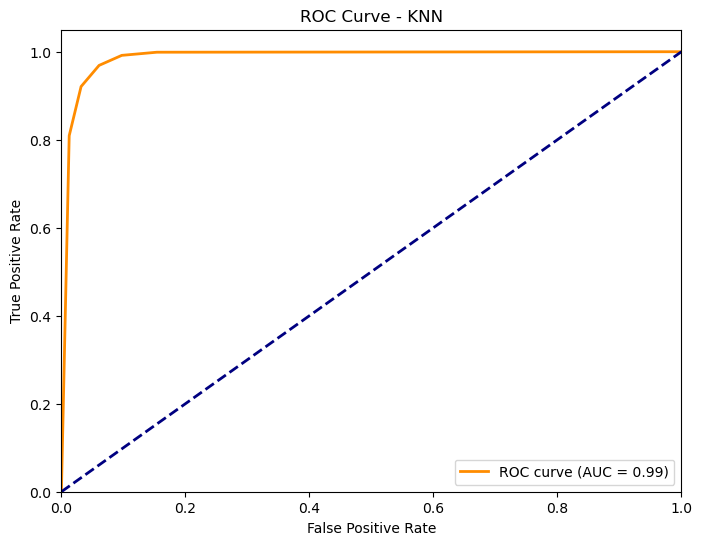


Training and evaluating Gradient Boosting...


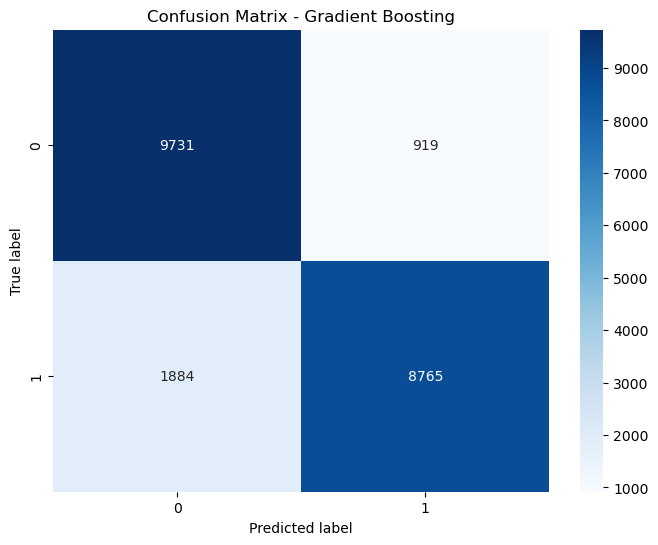

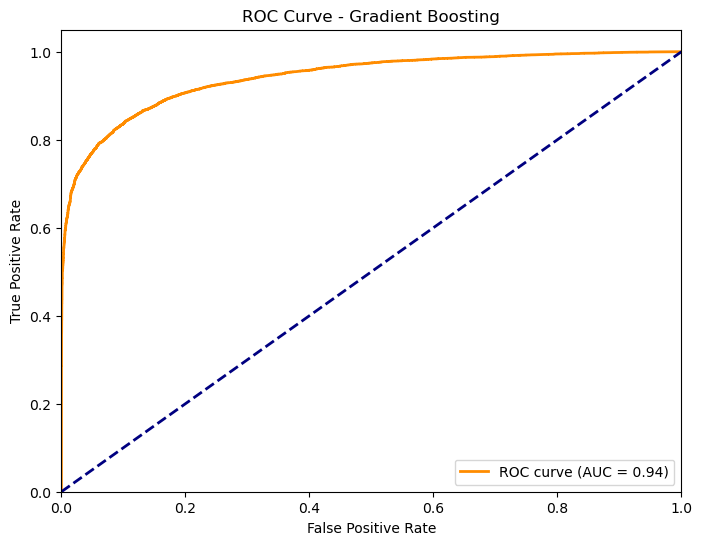


Model Evaluation Results:
                   Accuracy  Precision    Recall  F1-score   ROC-AUC
Random Forest      0.961219   0.955232  0.967790  0.961470  0.993765
Decision Tree      0.909855   0.907098  0.913231  0.910154  0.909855
KNN                0.954082   0.940994  0.968917  0.954752  0.986861
Gradient Boosting  0.868398   0.905101  0.823082  0.862145  0.941747


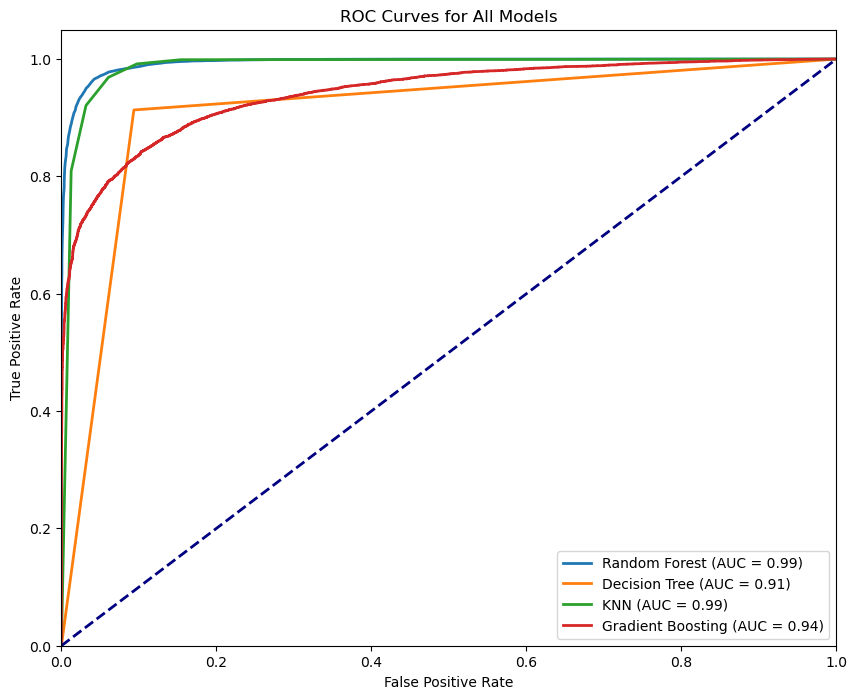


Training complete. Confusion matrices and ROC curves have been plotted.


In [11]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

# Load the datasets
train_df = pd.read_csv('train_set.csv')
val_df = pd.read_csv('validation_set.csv')
test_df = pd.read_csv('test_set.csv')

# Separate features and target
X_train = train_df.drop('Anomaly', axis=1)
y_train = train_df['Anomaly']
X_val = val_df.drop('Anomaly', axis=1)
y_val = val_df['Anomaly']
X_test = test_df.drop('Anomaly', axis=1)
y_test = test_df['Anomaly']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Train, validate, and test models
results = {}

for name, model in models.items():
    print(f"\nTraining and evaluating {name}...")
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions on validation set
    y_val_pred = model.predict(X_val_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, model.predict_proba(X_val_scaled)[:, 1])
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'ROC-AUC': roc_auc
    }
    
    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    plot_confusion_matrix(cm, f'Confusion Matrix - {name}')
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val_scaled)[:, 1])
    plot_roc_curve(fpr, tpr, roc_auc, f'ROC Curve - {name}')

# Print results
print("\nModel Evaluation Results:")
results_df = pd.DataFrame(results).T
print(results_df)

# Plot ROC curves for all models in one graph
plt.figure(figsize=(10, 8))
for name, model in models.items():
    fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val_scaled)[:, 1])
    roc_auc = roc_auc_score(y_val, model.predict_proba(X_val_scaled)[:, 1])
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.show()

print("\nTraining complete. Confusion matrices and ROC curves have been plotted.")

HYPER PARAMETER TUNING USING GRID SEARCH

Performing grid search for Random Forest with a subset of parameters...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Random Forest (subset):  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score (subset):  0.9551510015772285

Random Forest Evaluation Results after Grid Search (subset):
                        Accuracy  Precision    Recall  F1-score   ROC-AUC
Random Forest (subset)  0.961735   0.955953  0.968072  0.961975  0.994024

Random Forest grid search (subset) complete. ROC curve has been plotted and saved.


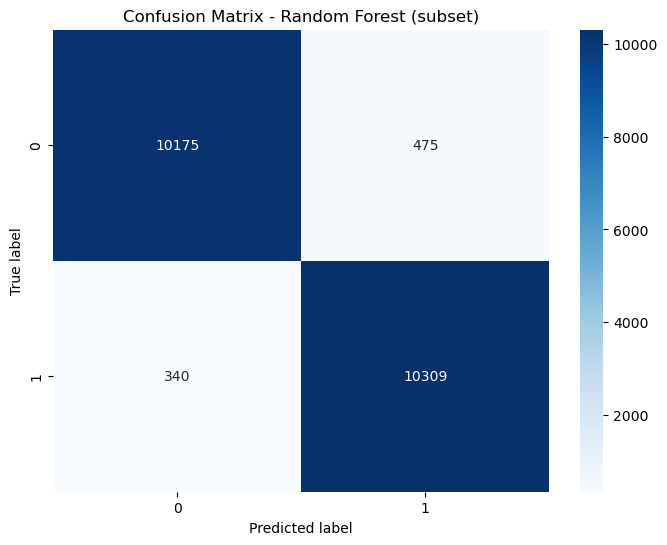

Confusion matrix for Random Forest (subset) has been plotted and saved.


In [12]:
from sklearn.model_selection import GridSearchCV


# Load the datasets
train_df = pd.read_csv('train_set.csv')
val_df = pd.read_csv('validation_set.csv')

# Separate features and target
X_train = train_df.drop('Anomaly', axis=1)
y_train = train_df['Anomaly']
X_val = val_df.drop('Anomaly', axis=1)
y_val = val_df['Anomaly']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Perform grid search for Random Forest with a subset of parameters
print("Performing grid search for Random Forest with a subset of parameters...")
rf_param_grid_subset = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf_grid_search_subset = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid_subset, cv=5, n_jobs=-1, verbose=1, scoring='f1')
rf_grid_search_subset.fit(X_train_scaled, y_train)
best_rf_model_subset = rf_grid_search_subset.best_estimator_
print("Best parameters for Random Forest (subset): ", rf_grid_search_subset.best_params_)
print("Best cross-validation score (subset): ", rf_grid_search_subset.best_score_)

# Evaluate the best Random Forest model on the validation set
rf_y_val_pred_subset = best_rf_model_subset.predict(X_val_scaled)
rf_accuracy_subset = accuracy_score(y_val, rf_y_val_pred_subset)
rf_precision_subset = precision_score(y_val, rf_y_val_pred_subset)
rf_recall_subset = recall_score(y_val, rf_y_val_pred_subset)
rf_f1_subset = f1_score(y_val, rf_y_val_pred_subset)
rf_roc_auc_subset = roc_auc_score(y_val, best_rf_model_subset.predict_proba(X_val_scaled)[:, 1])

rf_results_subset = {
    'Accuracy': rf_accuracy_subset,
    'Precision': rf_precision_subset,
    'Recall': rf_recall_subset,
    'F1-score': rf_f1_subset,
    'ROC-AUC': rf_roc_auc_subset
}

print("\nRandom Forest Evaluation Results after Grid Search (subset):")
print(pd.DataFrame(rf_results_subset, index=["Random Forest (subset)"]))

# Plot ROC curve for the best Random Forest model (subset)
from sklearn.metrics import roc_curve
rf_y_val_pred_proba_subset = best_rf_model_subset.predict_proba(X_val_scaled)[:, 1]
rf_fpr_subset, rf_tpr_subset, _ = roc_curve(y_val, rf_y_val_pred_proba_subset)
plt.figure(figsize=(10, 8))
plt.plot(rf_fpr_subset, rf_tpr_subset, lw=2, label='Random Forest (AUC = {:.2f})'.format(rf_roc_auc_subset))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest after Grid Search (subset)')
plt.legend(loc="lower right")
plt.savefig('roc_curve_rf_after_grid_search_subset.png')
plt.close()

print("\nRandom Forest grid search (subset) complete. ROC curve has been plotted and saved.")

# Plot confusion matrix for the best Random Forest model (subset)
rf_cm_subset = confusion_matrix(y_val, rf_y_val_pred_subset)
plot_confusion_matrix(rf_cm_subset, 'Confusion Matrix - Random Forest (subset)')
print("Confusion matrix for Random Forest (subset) has been plotted and saved.")

FEATURE IMPORTANCE

Feature Importances:
                                  feature  importance
0                      Population_Density    0.102835
1   Electricity_Consumption_per_Household    0.099024
2                          Total_cons_kwh    0.084454
3                         Median_cons_kwh    0.082133
4                                   Males    0.081238
5                     Occupied_Households    0.081181
6                              Num_meters    0.080975
7                           Mean_cons_kwh    0.073477
8                                 Females    0.071697
9                       Energy_Efficiency    0.067624
10                                  Total    0.062326
11                        Outcode_encoded    0.034381
12                             Unnamed: 0    0.031699
13                       Postcode_encoded    0.031123
14                                Cluster    0.015833


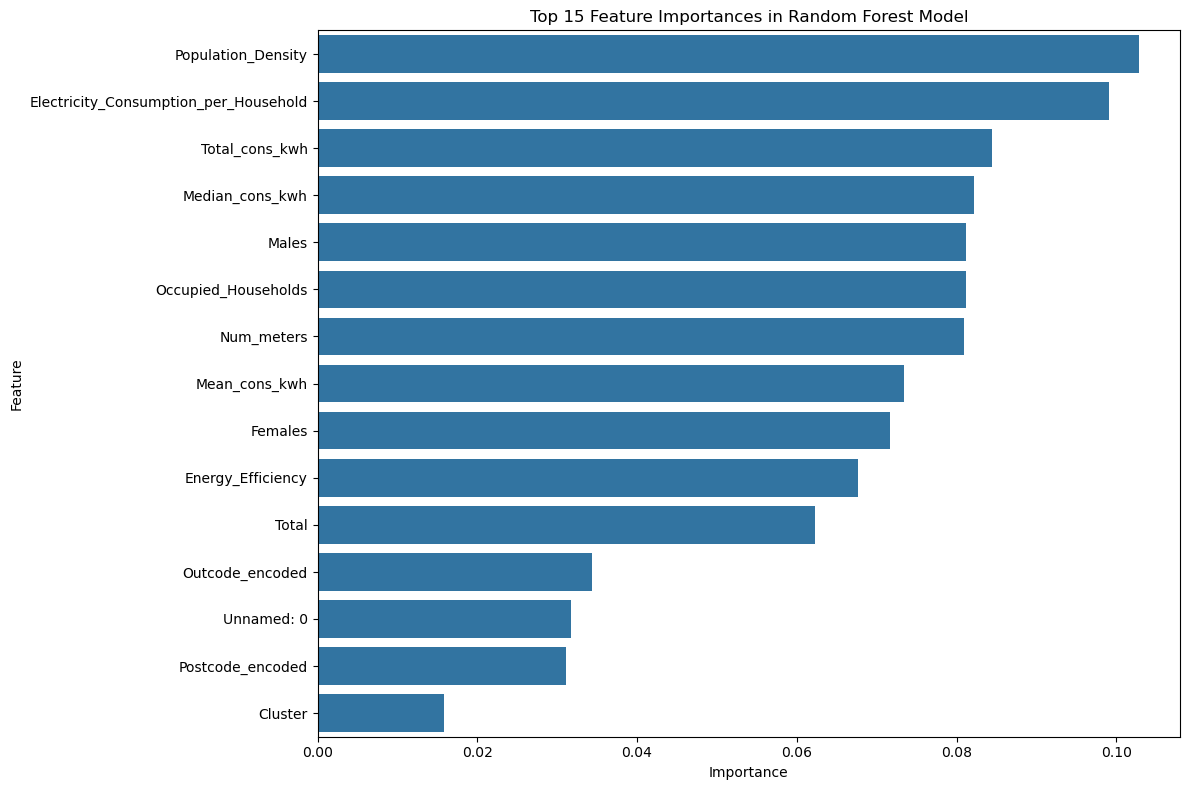


Number of features accounting for 95% of the importance: 12

Top features accounting for 95% of the importance:
['Population_Density', 'Electricity_Consumption_per_Household', 'Total_cons_kwh', 'Median_cons_kwh', 'Males', 'Occupied_Households', 'Num_meters', 'Mean_cons_kwh', 'Females', 'Energy_Efficiency', 'Total', 'Outcode_encoded']


In [13]:
# Get feature importances
importances = best_rf_model_subset.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)

# Print feature importances
print("Feature Importances:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Calculate cumulative importance
feature_importances['cumulative_importance'] = feature_importances['importance'].cumsum()

# Find number of features for 95% cumulative importance
features_for_95 = feature_importances[feature_importances['cumulative_importance'] <= 0.95].shape[0]
print(f"\nNumber of features accounting for 95% of the importance: {features_for_95}")

# Optionally, print these top features
print("\nTop features accounting for 95% of the importance:")
print(feature_importances.head(features_for_95)['feature'].tolist())

ERROR ANALYSIS ON MISCLASSIFIED DATAPOINTS

In [14]:
# Perform error analysis
y_pred = best_rf_model_subset.predict(X_val_scaled)
misclassified = X_val[y_val != y_pred].copy()
misclassified['true_label'] = y_val[y_val != y_pred]
misclassified['predicted_label'] = y_pred[y_val != y_pred]

# Add probability scores for the predicted class
probabilities = best_rf_model_subset.predict_proba(X_val_scaled[y_val != y_pred])
misclassified['probability_score'] = np.max(probabilities, axis=1)

# Sort by probability score to see the most "confident" misclassifications
misclassified_sorted = misclassified.sort_values('probability_score', ascending=False)

print("Number of misclassified instances:", len(misclassified))
print("\nTop 10 most confident misclassifications:")
misclassified_sorted.head(10)

Number of misclassified instances: 815

Top 10 most confident misclassifications:


,Unnamed: 0,Num_meters,Total_cons_kwh,Mean_cons_kwh,Median_cons_kwh,Total,Males,Females,Occupied_Households,Cluster,Electricity_Consumption_per_Household,Population_Density,Energy_Efficiency,Outcode_encoded,Postcode_encoded,true_label,predicted_label,probability_score
6123,0.465524,0.358147,0.033189,-0.340166,-0.127488,3.015884,2.768548,3.117364,2.147678,-0.430179,-0.328938,0.811333,-0.313026,0.471260,0.465511,0,1,0.975
20046,-0.693634,-0.659444,-0.745058,-1.106329,-0.630461,-1.284693,-1.424487,-1.086935,-1.382106,0.875016,-0.262363,-0.111311,-0.226049,-0.713865,-0.693653,1,0,0.965
3864,0.207067,-0.320247,-0.022176,0.736356,1.147059,-1.592720,-1.572476,-1.537812,-1.655916,-1.735373,1.858741,-0.657818,1.653134,0.190561,0.207057,0,1,0.950
9095,0.004620,1.714935,0.850493,-0.347906,-0.155495,2.489902,2.423239,2.438484,2.084285,-0.430179,-0.124151,0.447558,-0.178903,0.071956,0.004621,0,1,0.945
1700,-0.366662,-0.433313,-0.249728,0.343771,0.482998,-1.667860,-1.671136,-1.586303,-1.655916,0.875016,1.251900,-1.312980,1.716662,-0.382698,-0.366634,0,1,0.930
4255,-0.264086,2.280264,2.668665,0.799018,1.265400,-0.114961,0.006078,-0.228544,0.182488,-1.735373,1.082766,-0.439431,0.864461,-0.200836,-0.264043,0,1,0.930
15796,-0.499703,-0.659444,-0.462793,0.253763,-0.261265,-1.116832,-1.128508,-1.052898,-1.402343,0.875016,0.185227,0.870894,-0.043521,-0.489442,-0.499694,1,0,0.925
13009,1.097804,-0.320247,-0.299990,-0.100298,-0.401992,-0.766177,-0.437890,-1.052898,-1.021984,0.875016,0.067653,0.543313,-0.075345,0.985216,1.097802,1,0,0.910
4192,-0.947889,-0.659444,-0.608898,-0.450244,0.151331,-0.240656,-0.126579,-0.341492,-0.705018,0.875016,-0.317749,0.994537,-0.312463,-0.988862,-0.947905,1,0,0.905
8383,-0.759209,-0.433313,-0.201276,0.510533,0.569884,-0.640943,-0.536550,-0.713458,-1.275557,0.875016,0.409321,2.290411,-0.061325,-0.868979,-0.759238,0,1,0.905


In [15]:
# Analyze misclassifications by true label
misclassification_by_true_label = misclassified['true_label'].value_counts()
print("\nMisclassifications by true label:")
misclassification_by_true_label

# Calculate mean values for misclassified vs correctly classified instances
misclassified_mean = misclassified.mean()
correctly_classified_mean = X_val[y_val == y_pred].mean()

print("\nMean values for misclassified instances:")
print(misclassified_mean)
print("\nMean values for correctly classified instances:")
print(correctly_classified_mean)


Misclassifications by true label:

Mean values for misclassified instances:
Unnamed: 0                              -0.015761
Num_meters                               0.062591
Total_cons_kwh                           0.035445
Mean_cons_kwh                            0.121270
Median_cons_kwh                          0.093094
Total                                    0.124437
Males                                    0.136337
Females                                  0.106894
Occupied_Households                      0.183781
Cluster                                 -0.161132
Electricity_Consumption_per_Household    0.002913
Population_Density                       0.006965
Energy_Efficiency                       -0.006922
Outcode_encoded                         -0.009939
Postcode_encoded                        -0.015761
true_label                               0.417178
predicted_label                          0.582822
probability_score                        0.628307
dtype: float64

Mean va

In [16]:
# Calculate the difference in means
mean_difference = misclassified_mean - correctly_classified_mean
print("\nDifference in means (misclassified - correctly classified):")
mean_difference.sort_values(ascending=False)


Difference in means (misclassified - correctly classified):


Cluster                                  0.062857
Population_Density                       0.027755
Males                                    0.017555
Occupied_Households                      0.016154
Total                                    0.005618
Females                                 -0.006381
Outcode_encoded                         -0.025645
Postcode_encoded                        -0.026534
Unnamed: 0                              -0.026535
Mean_cons_kwh                           -0.122541
Median_cons_kwh                         -0.130163
Electricity_Consumption_per_Household   -0.217081
Energy_Efficiency                       -0.217437
Num_meters                              -0.276154
Total_cons_kwh                          -0.361013
predicted_label                               NaN
probability_score                             NaN
true_label                                    NaN
dtype: float64

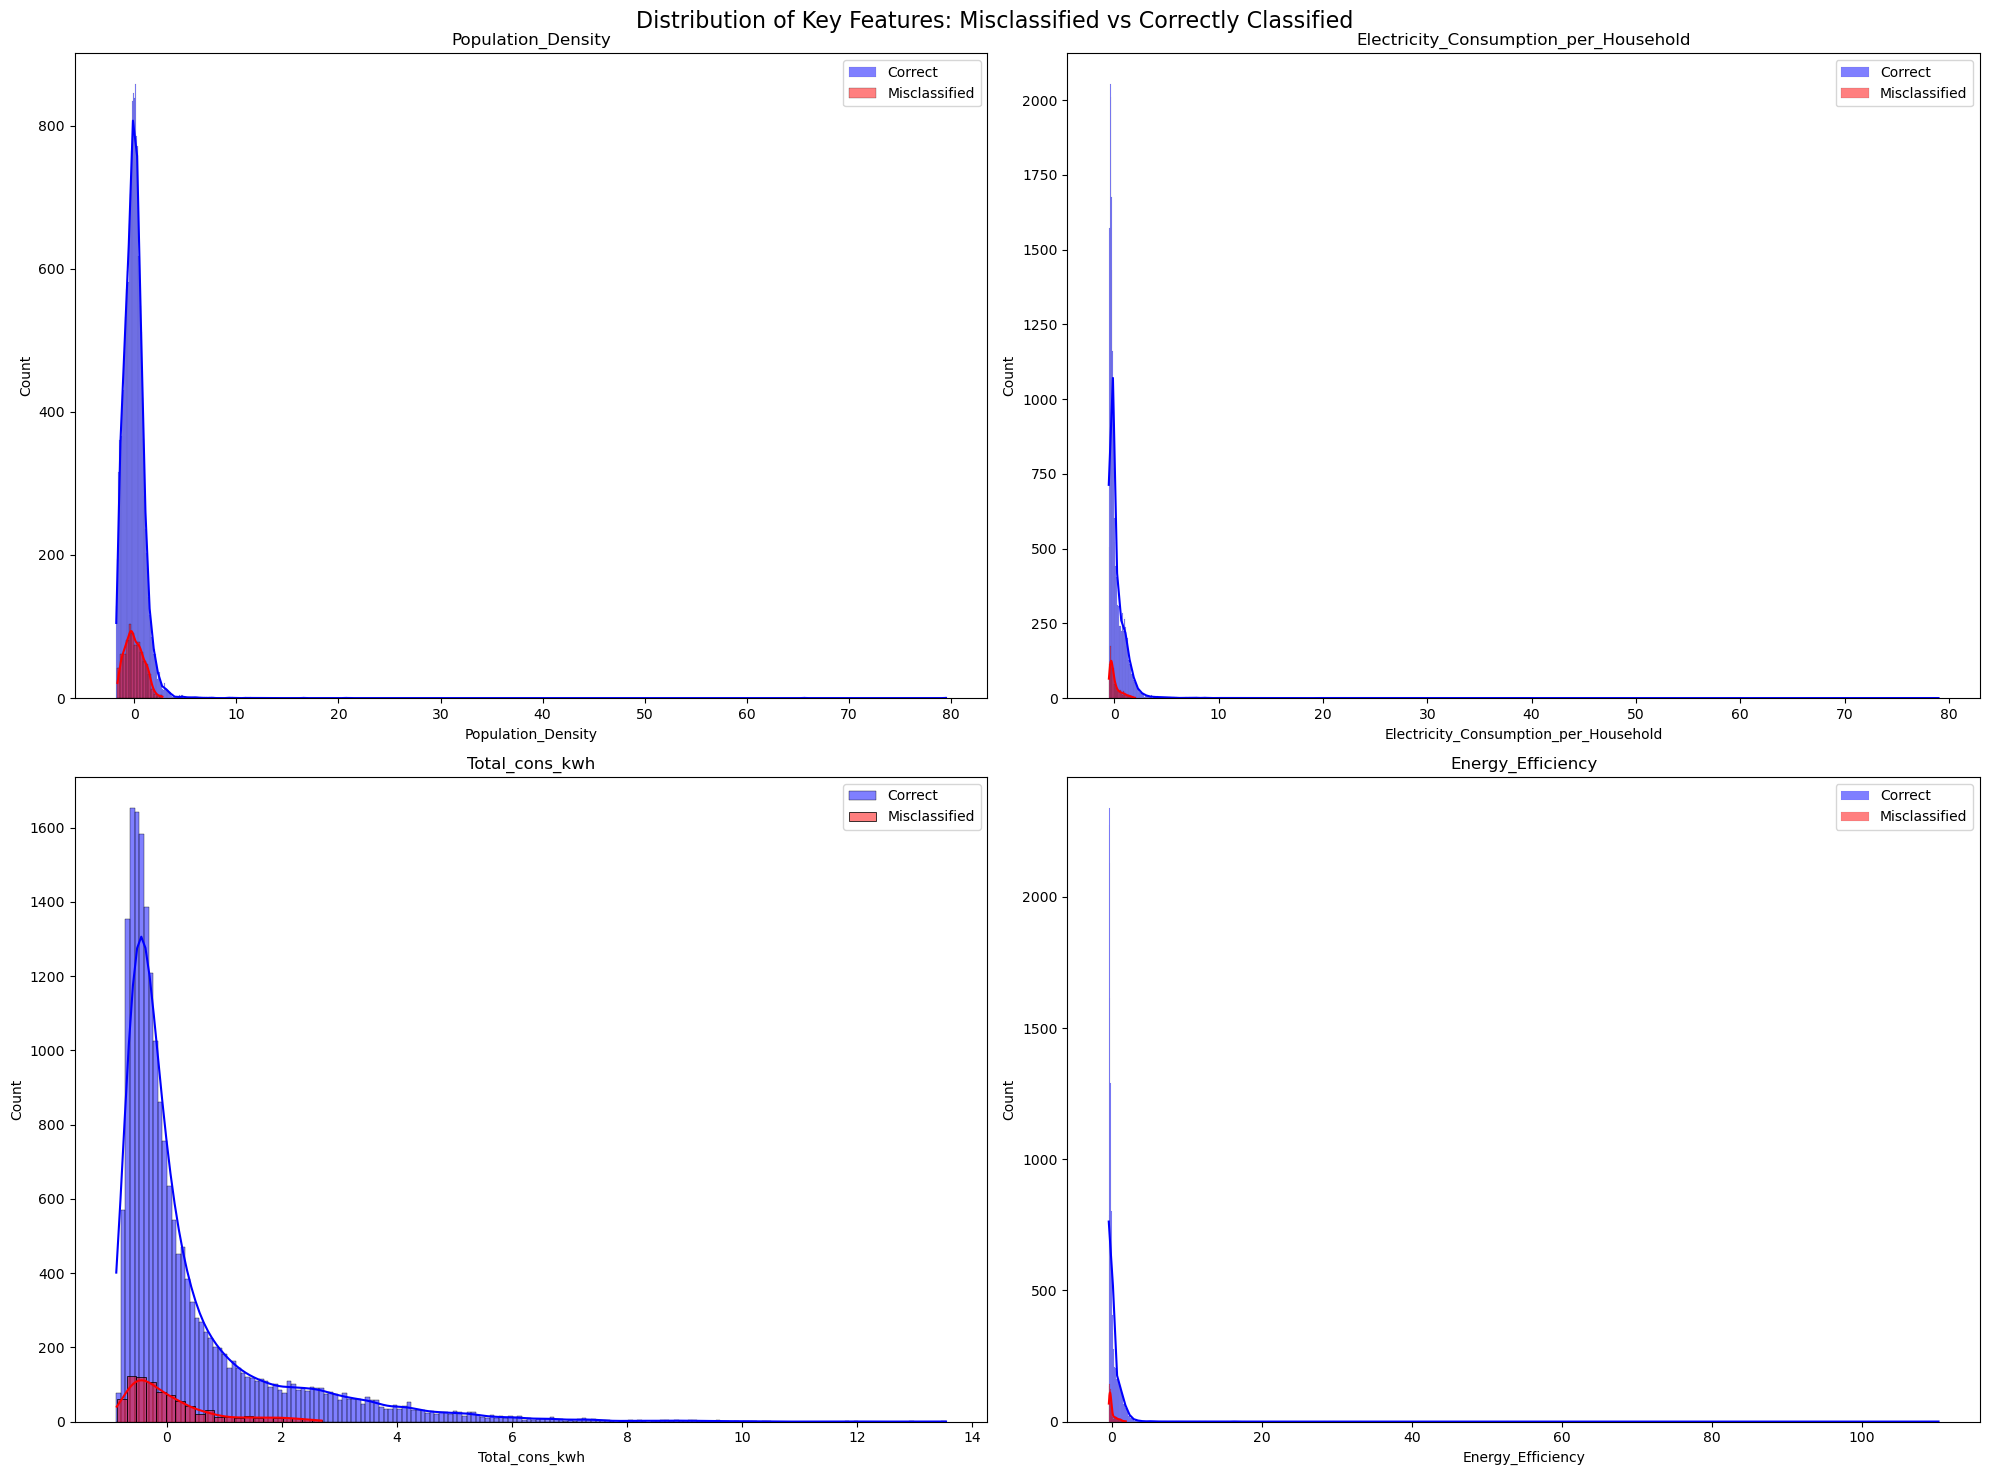

In [17]:
# Visualize the distribution of a few key features for misclassified vs correctly classified instances
key_features = ['Population_Density', 'Electricity_Consumption_per_Household', 'Total_cons_kwh', 'Energy_Efficiency']

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Distribution of Key Features: Misclassified vs Correctly Classified', fontsize=16)

for i, feature in enumerate(key_features):
    ax = axes[i // 2, i % 2]
    sns.histplot(data=X_val[y_val == y_pred], x=feature, kde=True, color='blue', alpha=0.5, ax=ax, label='Correct')
    sns.histplot(data=misclassified, x=feature, kde=True, color='red', alpha=0.5, ax=ax, label='Misclassified')
    ax.set_title(feature)
    ax.legend()

plt.tight_layout()
plt.show()

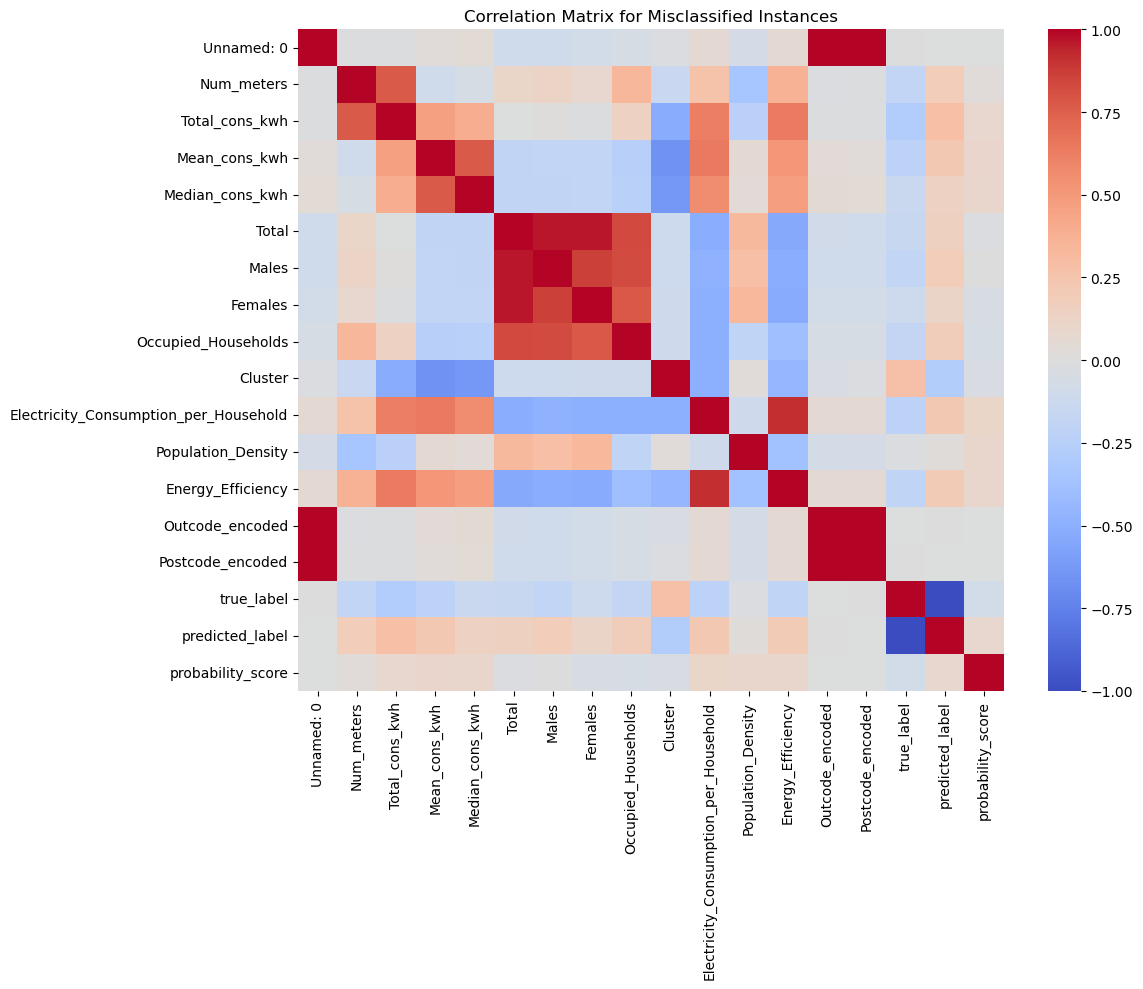

In [18]:
# Correlation analysis for misclassified instances
correlation_matrix = misclassified.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix for Misclassified Instances')
plt.tight_layout()
plt.show()

VISUALISATION OF THE TREES

In [19]:
#pip install graphviz
from sklearn.tree import export_graphviz
import graphviz

# Visualize a few trees from the Random Forest
num_trees_to_visualize = 3

for i in range(num_trees_to_visualize):
    tree = best_rf_model_subset.estimators_[i]
    dot_data = export_graphviz(tree, out_file=None, 
                               feature_names=X_train.columns, 
                               filled=True, rounded=True, 
                               special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.render(f'random_forest_tree_{i}')

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH